## Homework

Write a generator for electron - positron pairs from the Z boson decay. Assume the Z boson is at rest, and its mass is ditributed according to the 
Breit-Wigner (BW) distribution with $m_{Z} = 92.1876$, $\Gamma = 2.4952$.

* generate events with the pair energy in range [50,200]
* assume the decay is isotropic (is this fully correct?)
* generate at least 500k events. How long it takes? What is the generation effciency?
* plot histogram of the pair invariant mass with linear and log Y scales. Overlay with probability distribution for invariant mass
* plot histogram of  $cos(\theta)$ of electrons moementum
* plot histogram of transverse electron momentum $p_{T}$. Overlay with probability distribution for transverse momentum.

**Hints:** 
* the probability distibution for the $p_{T}$ can be obtained from the chain rule:

\begin{equation}
\frac{d\sigma}{dp_{T}} =  \frac{d\sigma}{d\cos(\theta)} \frac{d\cos(\theta)}{dp_{T}}
\end{equation}

* use the nominal Z boson mass while calculating the $\frac{d\sigma}{dp_{T}}$.

Setup of our environment

In [ ]:
#import ROOT

#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np

#HEP specific tools
import scipy.constants as scipy_constants

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [ ]:
G_F = scipy_constants.physical_constants["Fermi coupling constant"]
m_e = scipy_constants.physical_constants["electron mass energy equivalent in MeV"]
m_mu = scipy_constants.physical_constants["muon mass energy equivalent in MeV"]

print("Fermi constant: {} +- {} {}".format(G_F[0], G_F[2], G_F[1]))
print("muon mass: \t{} +- {} {}".format(m_mu[0], m_mu[2], m_mu[1]))
print("electron mass: \t{} +- {} {}".format(m_e[0], m_e[2], m_e[1]))

G_F = G_F[0]
m_e = m_e[0]
m_mu = m_mu[0]

## Our homework functions

In [25]:
minS = 50
maxS = 200

m_Z = 92.1876
gamma_Z = 2.4952

def BreitWigner(s, m, gamma):
    gamma_small = np.sqrt(m ** 2 * (m ** 2 + gamma ** 2))
    k = (2 * np.sqrt(2) * m * gamma * gamma_small) / (np.pi * np.sqrt(m ** 2 + gamma_small))
    
    distr = k / ((s ** 2 - m ** 2) ** 2 + m ** 2 * gamma ** 2)
    return distr

def generateCandidateEnergy(nPoints):
    gamma = gamma_Z
    s = (maxS-minS)*np.random.random(nPoints) + minS
    print(s)
    x = np.random.random_sample(nPoints)
    bw_values = BreitWigner(s, m_Z, gamma)  # it is equivalent to p
    bw_values = bw_values / np.max(bw_values)
    accepted = x < bw_values
    return s[accepted]/2.0

def generateCandidateMomenta(energy):
    howmany = len(energy)
    
    c = np.random.random_sample([howmany, 3]) 
    csum = np.sum(c, axis=1)  # we need to generate shoots so that their sum equals energy
    cdiv = np.asanyarray(1 / csum)  # vector we multiply our matrix
    cdivT = np.vstack(cdiv)  # transposed vector

    result = np.multiply(c, cdivT)  # matrix multiplied  by sum
    energyT = np.vstack(energy)  # transposed vector of energies
    
    p = np.multiply(result, energyT)    # we multiply our matrix by energy to get momenta sum equal to energy
    
    px = p[:, 0]    # our momenta
    py = p[:, 1]
    pz = p[:, 2]
   
    p4_electron = np.column_stack([energy, px,py,pz])
    p4_positron = np.column_stack([energy, -px,-py,-pz])
    return  p4_electron, p4_positron

def generateEvents(nPoints):
    energy = generateCandidateEnergy(nPoints)
    data = generateCandidateMomenta(energy)
    return data

def invMass(p4):
    metric = np.array([1,-1,-1,-1])
    p4_square = p4*(metric*p4)
    m = np.sqrt(np.sum(p4_square, axis=1))
    return m

def pdf_invMass(m, m_Z, gamma_Z):
    p = np.where(np.logical_and(m>50, m<200), BreitWigner(m, m_Z, gamma_Z), 0)
    return p


## Here are energies generated

In [ ]:
nPoints = 50000

e_min = 50
e_max = 200

energies = generateCandidateEnergy(nPoints)
print("Number of accepted events:\t",energies.shape[0])
print("Accepted events fraction:\t",energies.shape[0]/nPoints)

## Here are momenta generated


In [ ]:
b = generateCandidateMomenta(energies)

## First test plots

[153.32495963 156.78785042 189.59743059 ... 165.19251288 177.42026307
 198.73186397]
Generated 25764 events for 1000000 tries. 
Efficiency: 0.03


No handles with labels found to put in legend.


CPU times: user 221 ms, sys: 8.02 ms, total: 229 ms
Wall time: 226 ms


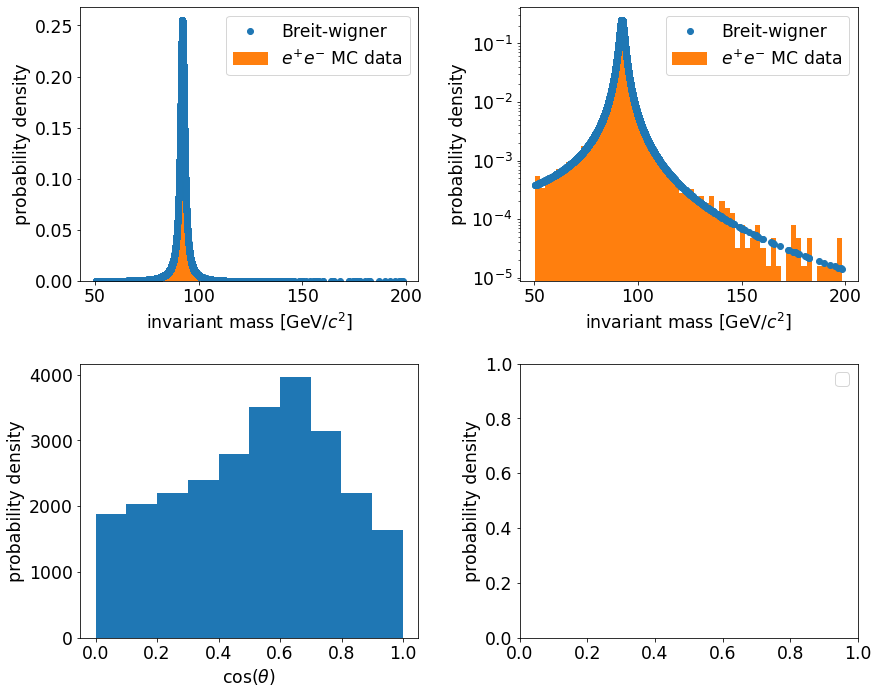

In [46]:
%%time

nPoints = 1000000
p4_electron, p4_positron = generateEvents(nPoints)
m = invMass(p4_electron + p4_positron)
print("Generated {} events for {} tries. \nEfficiency: {:3.2f}".format(m.shape[0], nPoints, float(m.shape[0])/nPoints))

invMasspdf = pdf_invMass(m, m_Z, gamma_Z)

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes[0,0].plot(m, BreitWigner(m, m_Z, gamma_Z), "o",label="Breit-wigner");
axes[0,0].hist(m, bins=60, density=True, label=r"$e^{+}e^{-}$ MC data");
axes[0,0].set_xlabel(r"invariant mass [GeV/$c^{2}$]")
axes[0,0].set_ylabel("probability density")
axes[0,0].legend(loc="upper right");

axes[0,1].plot(m, BreitWigner(m, m_Z, gamma_Z), "o",label="Breit-wigner");
axes[0,1].hist(m, bins=60, density=True, label=r"$e^{+}e^{-}$ MC data");
axes[0,1].set_xlabel(r"invariant mass [GeV/$c^{2}$]")
axes[0,1].set_ylabel("probability density")
axes[0,1].set_yscale("log")
axes[0,1].legend(loc="upper right");

pT = np.sqrt(np.sum(p4_electron[:,1:3]*p4_electron[:,1:3], axis=1))
pL = p4_electron[:,3]
p = np.sqrt(p4_electron[:, 1] ** 2 + p4_electron[:, 2] ** 2 + p4_electron[:, 3] ** 2)

cosTheta = pL/p
axes[1,0].hist(cosTheta, label="electrons");
axes[1,0].set_xlabel(r"$\cos(\theta)$")
axes[1,0].set_ylabel("probability density")

# pT_dist = ...
# pT_dist = np.where(pT_dist<0.08, pT_dist, 0)
# axes[1,1].plot(pT, pT_dist,"o" ,label=r"$\frac{1}{\sigma_{0}}\frac{d\sigma}{dp_{T}}$");
# axes[1,1].hist(..., label="electron\nMC data");
# axes[1,1].set_xlabel(r"$p_{T}$[GeV/c]")
axes[1,1].set_ylabel("probability density")
axes[1,1].legend(loc="upper right");

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3, hspace=0.3)

[91.63551535 99.33030433 92.1880499  ... 88.17996387 91.23037734
 88.87612075]


(array([4.02171678e-04, 6.78991145e-04, 1.04982477e-03, 1.71836990e-03,
        6.97793976e-03, 1.05969626e-01, 1.39506565e-02, 2.04741945e-03,
        6.47653092e-04, 4.07394687e-04, 2.24589379e-04, 1.25352211e-04,
        5.74530969e-05, 9.40141585e-05, 5.74530969e-05, 6.26761057e-05,
        2.08920352e-05, 2.61150440e-05, 1.04460176e-05, 2.08920352e-05]),
 array([ 50.10826362,  57.54044884,  64.97263406,  72.40481928,
         79.83700451,  87.26918973,  94.70137495, 102.13356017,
        109.56574539, 116.99793061, 124.43011584, 131.86230106,
        139.29448628, 146.7266715 , 154.15885672, 161.59104194,
        169.02322717, 176.45541239, 183.88759761, 191.31978283,
        198.75196805]),
 <BarContainer object of 20 artists>)

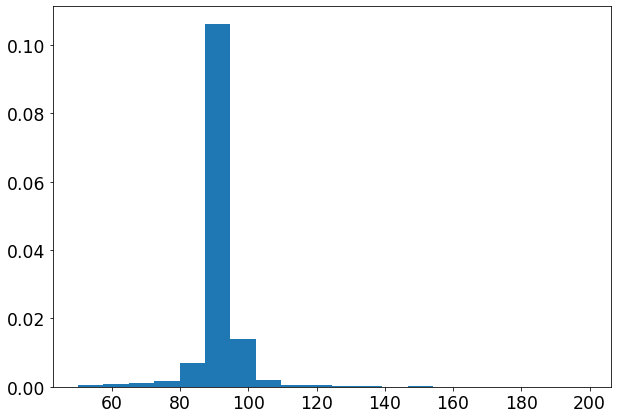

In [40]:
print(m)

plt.hist(m, bins=20, density=True)